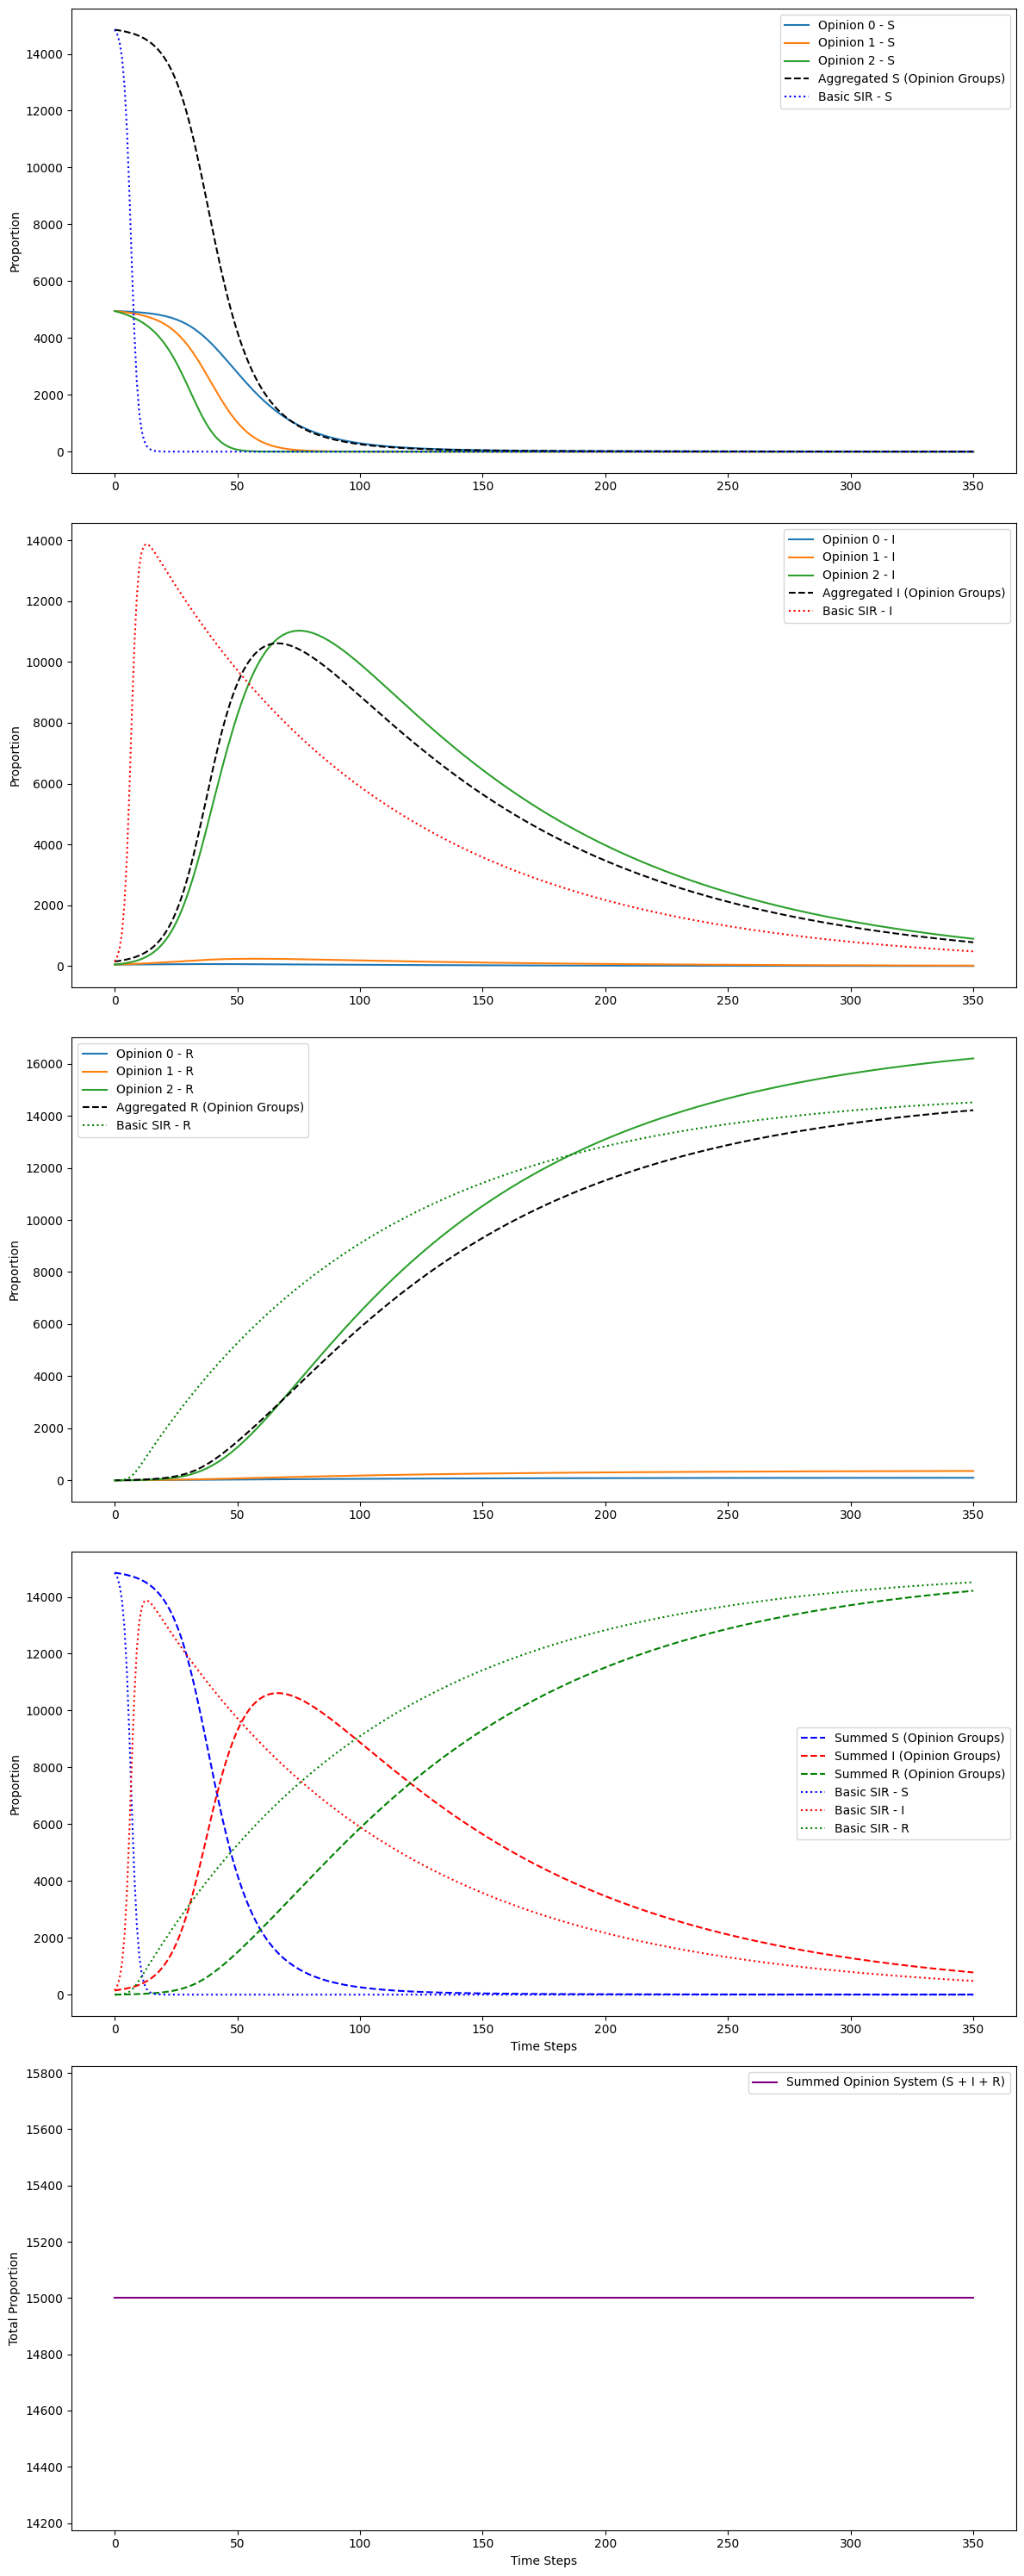

Optimized Beta: 1.0
Optimized Gamma: 0.00049342919455492


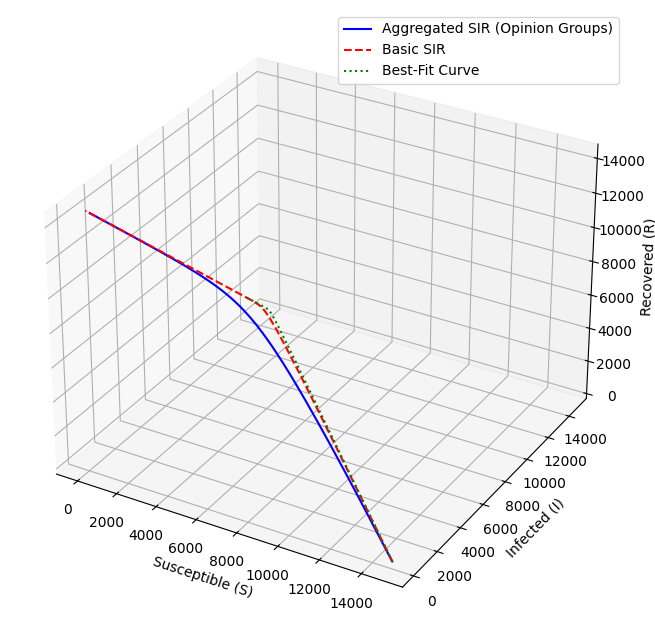

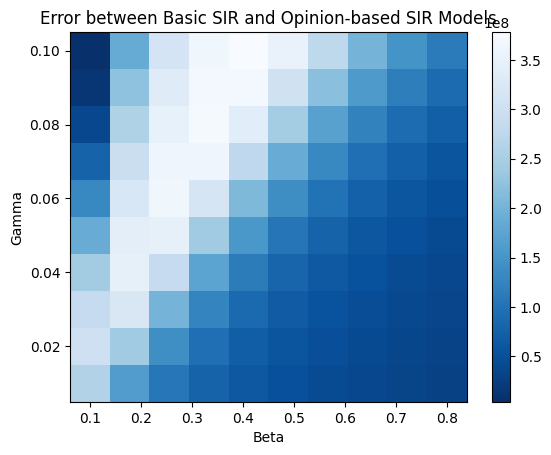

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize

# Basic SIR model parameters and initial values
N = 15000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R
beta = 0.7
gamma = 0.01
MaxTime = 350
RunTime = np.linspace(0, MaxTime, MaxTime)

# Number of opinion groups (indexed from 0 to n)
n = 2  # The total number of opinion groups

# Probability distribution over the opinions
def pi(q, n):
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': int_S / (n + 1) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': int_I / (n + 1) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': int_R / (n + 1) for i in range(n + 1)})

# Convert initial_values to a list
initial_conditions = [initial_values[f'P_S_{i}'] for i in range(n + 1)] + \
                     [initial_values[f'P_I_{i}'] for i in range(n + 1)] + \
                     [initial_values[f'P_R_{i}'] for i in range(n + 1)]

# Differential equations for the SIR model with opinions
def sir_opinion_system(y, t, N, beta, gamma, n):
    S = y[:n + 1]
    I = y[n + 1:2 * (n + 1)]
    R = y[2 * (n + 1):]
    
    dSdt = np.zeros(n + 1)
    dIdt = np.zeros(n + 1)
    dRdt = np.zeros(n + 1)
    
    for i in range(n + 1):
        dSdt[i] = -pi(i, n) * beta * S[i] * np.sum(I) / N
        dIdt[i] = pi(i, n) * beta * I[i] * np.sum(S) / (3 * N) - gamma * I[i]
        dRdt[i] = gamma * I[i]
    
    return np.concatenate([dSdt, dIdt, dRdt])

# Integrate the system of differential equations for the SIR model with opinions
result = odeint(sir_opinion_system, initial_conditions, RunTime, args=(N, beta, gamma, n))

# Extract S, I, R for each opinion group
S = result[:, :n + 1]
I = result[:, n + 1:2 * (n + 1)]
R = result[:, 2 * (n + 1):]

# Aggregate the opinion-based model values
aggregated_S = S.sum(axis=1)
aggregated_I = I.sum(axis=1)
aggregated_R = R.sum(axis=1)

# Normalize the summed opinion system so that it does not exceed N
aggregated_total = aggregated_S + aggregated_I + aggregated_R
normalizing_factor = N / aggregated_total
aggregated_n_S = aggregated_S * normalizing_factor
aggregated_n_I = aggregated_I * normalizing_factor
aggregated_n_R = aggregated_R * normalizing_factor

# Sum of S, I, R values from the opinion groups model
summed_opinion_system = aggregated_n_S + aggregated_n_I + aggregated_n_R

# Integrate the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Function to plot the simulation results
def plot_simulation_combined(aggregated_n_S, aggregated_n_I, aggregated_n_R, basic_S, basic_I, basic_R, summed_opinion_system, RunTime, n):
    fig, axes = plt.subplots(5, 1, figsize=(12, 30))

    # Plot S, I, R for each opinion group
    for i in range(n + 1):
        axes[0].plot(RunTime, S[:, i], label=f'Opinion {i} - S')
        axes[1].plot(RunTime, I[:, i], label=f'Opinion {i} - I')
        axes[2].plot(RunTime, R[:, i], label=f'Opinion {i} - R')

    # Plot aggregated opinion-based model values
    axes[0].plot(RunTime, aggregated_n_S, label='Aggregated S (Opinion Groups)', color='black', linestyle='--')
    axes[1].plot(RunTime, aggregated_n_I, label='Aggregated I (Opinion Groups)', color='black', linestyle='--')
    axes[2].plot(RunTime, aggregated_n_R, label='Aggregated R (Opinion Groups)', color='black', linestyle='--')

    # Plot basic SIR model results
    axes[0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[1].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[2].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')

    # Set labels and legend for individual plots
    for i in range(3):
        axes[i].set_ylabel('Proportion')
        axes[i].legend()

    # Plot summed SIR proportions separately
    axes[3].plot(RunTime, aggregated_n_S, label='Summed S (Opinion Groups)', color='blue', linestyle='--')
    axes[3].plot(RunTime, aggregated_n_I, label='Summed I (Opinion Groups)', color='red', linestyle='--')
    axes[3].plot(RunTime, aggregated_n_R, label='Summed R (Opinion Groups)', color='green', linestyle='--')
    axes[3].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[3].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[3].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')
    axes[3].set_xlabel('Time Steps')
    axes[3].set_ylabel('Proportion')
    axes[3].legend()

    # Plot summed opinion system
    axes[4].plot(RunTime, summed_opinion_system, label='Summed Opinion System (S + I + R)', color='purple')
    axes[4].set_xlabel('Time Steps')
    axes[4].set_ylabel('Total Proportion')
    axes[4].legend()

    plt.tight_layout()
    plt.show()

# Plot the results for both the basic SIR model and the opinion groups SIR model
plot_simulation_combined(aggregated_n_S, aggregated_n_I, aggregated_n_R, basic_S, basic_I, basic_R, summed_opinion_system, RunTime, n)

# Define the objective function to calculate MSE between models
def objective(params):
    beta_a, gamma_a = params
    
    # Solve the basic SIR model with the given beta and gamma
    sol_basic = odeint(Find_Deriv, y_0, RunTime, args=(N, beta_a, gamma_a))
    S_basic, I_basic, R_basic = sol_basic.T
    
    # Solve the opinion-based SIR model with the given beta and gamma
    sol_opinion = odeint(sir_opinion_system, initial_conditions, RunTime, args=(N, beta_a, gamma_a, n))
    S_opinion = sol_opinion[:, :n + 1]
    I_opinion = sol_opinion[:, n + 1:2 * (n + 1)]
    R_opinion = sol_opinion[:, 2 * (n + 1):]
    
    # Aggregate the opinion-based model values
    aggregated_S = S_opinion.sum(axis=1)
    aggregated_I = I_opinion.sum(axis=1)
    aggregated_R = R_opinion.sum(axis=1)

    # Normalize the summed opinion system
    aggregated_total = aggregated_S + aggregated_I + aggregated_R
    normalizing_factor = N / aggregated_total
    aggregated_n_S = aggregated_S * normalizing_factor
    aggregated_n_I = aggregated_I * normalizing_factor
    aggregated_n_R = aggregated_R * normalizing_factor

    # Compute the error (MSE) between the models
    error = np.mean((S_basic - aggregated_n_S)**2 + (I_basic - aggregated_n_I)**2 + (R_basic - aggregated_n_R)**2)
    
    return error

# Initial guess for the optimization
initial_guess = [0.7, 0.01]

# Perform the optimization to find the best-fit beta and gamma values
result = minimize(objective, initial_guess, bounds=[(0, 1), (0, 1)])
optimized_beta, optimized_gamma = result.x

print(f"Optimized Beta: {optimized_beta}")
print(f"Optimized Gamma: {optimized_gamma}")

# Recompute the best-fit curves using the optimized parameters
sol_basic = odeint(Find_Deriv, y_0, RunTime, args=(N, optimized_beta, optimized_gamma))
S_basic_opt, I_basic_opt, R_basic_opt = sol_basic.T

sol_opinion = odeint(sir_opinion_system, initial_conditions, RunTime, args=(N, optimized_beta, optimized_gamma, n))
S_opinion_opt = sol_opinion[:, :n + 1]
I_opinion_opt = sol_opinion[:, n + 1:2 * (n + 1)]
R_opinion_opt = sol_opinion[:, 2 * (n + 1):]

# Aggregate and normalize the opinion-based model values
aggregated_S_opt = S_opinion_opt.sum(axis=1)
aggregated_I_opt = I_opinion_opt.sum(axis=1)
aggregated_R_opt = R_opinion_opt.sum(axis=1)

aggregated_total_opt = aggregated_S_opt + aggregated_I_opt + aggregated_R_opt
normalizing_factor_opt = N / aggregated_total_opt
aggregated_n_S_opt = aggregated_S_opt * normalizing_factor_opt
aggregated_n_I_opt = aggregated_I_opt * normalizing_factor_opt
aggregated_n_R_opt = aggregated_R_opt * normalizing_factor_opt

def plot_3d_combined_with_fit(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the trajectory in the SIR phase space for the opinion groups model
    ax.plot(aggregated_S, aggregated_I, aggregated_R, label='Aggregated SIR (Opinion Groups)', color='blue')
    
    # Plot the trajectory in the SIR phase space for the basic SIR model
    ax.plot(basic_S, basic_I, basic_R, label='Basic SIR', color='red', linestyle='--')
    
    # Plot the best-fit curve
    ax.plot(fitted_S, fitted_I, fitted_R, label='Best-Fit Curve', color='green', linestyle=':')
    
    # Label the axes
    ax.set_xlabel('Susceptible (S)')
    ax.set_ylabel('Infected (I)')
    ax.set_zlabel('Recovered (R)')
    
    ax.legend()
    plt.show()

# Call the plotting function with optimized parameters
plot_3d_combined_with_fit(aggregated_n_S, aggregated_n_I, aggregated_n_R, basic_S, basic_I, basic_R, aggregated_n_S_opt, aggregated_n_I_opt, aggregated_n_R_opt)

# Define the range of beta and gamma values for the grid search
beta_vals = np.linspace(0.1, 0.8, 10)
gamma_vals = np.linspace(0.01, 0.1, 10)
errors = np.zeros((len(beta_vals), len(gamma_vals)))

# Compute the error for each combination of beta and gamma values
for i, beta_a in enumerate(beta_vals):
    for j, gamma_a in enumerate(gamma_vals):
        errors[i, j] = objective([beta_a, gamma_a])

# Plot the error heatmap
fig, ax = plt.subplots()
c = ax.pcolormesh(beta_vals, gamma_vals, errors.T, cmap='Blues_r', shading='auto')
ax.set_xlabel('Beta')
ax.set_ylabel('Gamma')
fig.colorbar(c, ax=ax)
plt.title('Error between Basic SIR and Opinion-based SIR Models')
plt.show()
